In [1]:
#Loading necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
from collections import Counter
import re


from sklearn.model_selection import train_test_split # to split the data
from sklearn.model_selection import cross_val_score, KFold

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
#from mlxtend.regressor import StackingCVRegressor


from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading the dataset from the csv file

df = pd.read_csv("b.csv")

In [3]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [4]:
#Checking the dataset dimensions

df.shape

(13320, 9)

In [5]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


Data Exploration

In [6]:
#Checking the number of different categories in each categorical columns 
#area_type	availability	location	size	society	total_sqft

cat_col = ['area_type','availability','location','size','society','total_sqft']
           
for i in cat_col:
    print('# of categories in', i, ':',len(df[i].unique()))
           

# of categories in area_type : 4
# of categories in availability : 81
# of categories in location : 1306
# of categories in size : 32
# of categories in society : 2689
# of categories in total_sqft : 2117


In [7]:
# Checking the number of Null Values in each column 

print("Count total NaN at each column in a DataFrame :\n\n", df.isnull().sum()) 

Count total NaN at each column in a DataFrame :

 area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64


In [8]:
#5 variables has missing values and some of these has higher concentration of missing values like in society and balcony.

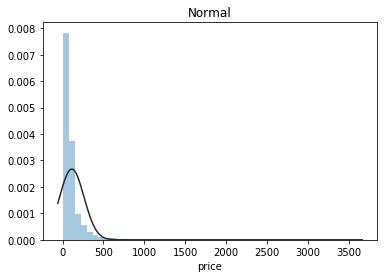

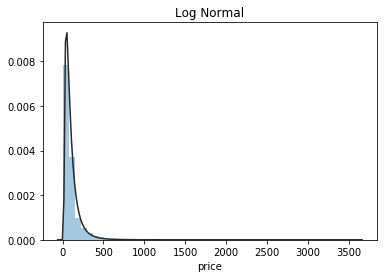

In [9]:
#Checking the distribution of Price variable

y = df['price']

#Normal Distribution curve
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)

#Log normal distributio curve
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [10]:
#Price doesn't follow the normal distribution, so before performing regression it has to be transformed.

Data Cleaning & Feature Engineering

In [11]:
'''
Availability 
==> Creating buckets based on the Month ==> "Ready to Move" and "Immediate Possession" will have value = 0 and rest will 
    be 1, 2, 3, etc based on the month
'''

def month_string_to_number(month_list):
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr': 4,
        'may': 5,
        'jun': 6,
        'jul': 7,
        'aug': 8,
        'sep': 9,
        'oct': 10,
        'nov': 11,
        'dec': 12,
        'Immediate Possession' : 0,
        'Ready To Move' : 0,
        'Other' : 0
        }

    s = ['Other' if x == 'Immediate Possession' or x == 'Ready To Move' 
              else x.split("-")[1].strip()[:3].lower() for x in month_list]
    month = [m[x] for x in s]
    return month


df['availability'] = month_string_to_number(df['availability'])


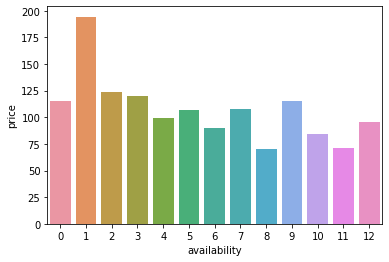

In [12]:
#Checking the distribution of availability

temp = df[['availability', 'price']].groupby(by=['availability']).mean().reset_index()
sns.barplot(x = temp['availability'], y = temp['price'] )

In [13]:
'''
#Location 
==> Since Location variable has one NULL value, Impute the null value with "Other"
==> After handling null values, Bucket the Location Variable based on the count of locations, replace locations with 
count < 50 with "Others"

'''

#Imputing Null Value with "Other"
df["location"].fillna("Other", inplace = True) 


#Creating buckets based on the frequency of category(location in this case)

loc_count = Counter(df['location'])
loc = []
for i in df['location']:
    if loc_count[i] < 10:
        temp = 'Other'
    else:
        temp = i
    loc.append(temp)
    
df['location'] = loc

In [14]:
'''
#SIZE 
==> Need to make the name "BHK", "BEDROOM" consistent
==> There are some missing values, Impute the median value based on Society, Location and Area_Type 
==> Bucket the size Variable based on the frequency

'''

#Extracting just the numerical part of the size to make it consistent

df['size'] = df['size'].fillna('Other')
df['size'] = [x.split(' ')[0] for x in df['size']]
df['size'] = [int(-1) if x == 'Other' else int(x) for x in df['size']]


#Replacing the null value with the median value of the column
median_size = df[df['size'] > 0]['size'].median()
df['size'] = [int(median_size) if x <0 else x for x in df['size']]


#Creating buckets based on the frequency of category(location in this case)
size_count = Counter(df['size'])
size = []
for i in df['size']:
    if size_count[i] <= 10:
        temp = 10
    else:
        temp = i
    size.append(temp)
    
df['size'] = size

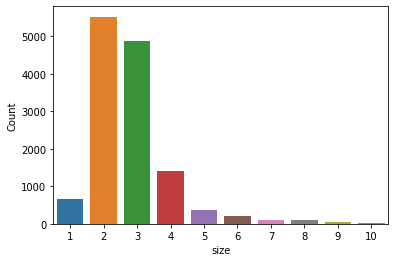

In [15]:
#Checking the distribution of size after binning


temp = df[['size', 'price']].groupby(by=['size']).count().reset_index().rename(columns={"price": "Count"})
sns.barplot(x = temp['size'], y = temp['Count'] )


#Majority of the records are having 1,2,3, and 4 bedroom

In [16]:
'''
#Society 
==> Impute the null values with "Other"
==> After handling null values, Bucket the Society Variable based on the count of locations, replace locations with 
count < 50 with "Others"

'''

#Imputing Null Value with "Other"
df["society"].fillna("Other", inplace = True) 


#Creating buckets based on the frequency of category(Society in this case)
#Frequency threshold is choosen based on distribution of the categories inside Society

soc_count = Counter(df['society'])
soc = []
for i in df['society']:
    if soc_count[i] < 5:
        temp = 'Other'
    else:
        temp = i
    soc.append(temp)
    
df['society'] = soc

In [17]:
'''
#total_sqft 
==> Convert the values to Sq. Ft
==> Take the avg of Sq. Ft where there is a range

'''

temp = []
for x in df['total_sqft']:
    
    if 'Meter' in x or 'Meters' in x:
        temp1 = re.findall(r'\d+', x)
        res2 = list(map(str, temp1))
        if len(res2)>1:
            temp.append(round(float(res2[0] + '.' + res2[1]) * 10.7639))
        else:
            temp.append(round(float(res2[0]) * 10.7639))
        
    elif 'Yards' in x or 'Yard' in x:
        temp1 = re.findall(r'\d+', x)
        res2 = list(map(str, temp1))
        if len(res2)>1:
            temp.append(round(float(res2[0] + '.' + res2[1]) * 9))
        else:
            temp.append(round(float(res2[0]) * 9))
        
    elif 'Acres' in x or 'Acre' in x:
        temp1 = re.findall(r'\d+', x)
        res2 = list(map(str, temp1))
        if len(res2)>1:
            temp.append(round(float(res2[0] + '.' + res2[1]) * 43560))
        else:
            temp.append(round(float(res2[0]) * 43560))
    
    elif x.isalnum():
        temp1 = re.findall(r'\d+', x)
        res2 = list(map(int, temp1))
        temp.append(res2[0])
        
    elif '-' in x:
        temp1 = x.split('-')
        temp1 = [float(x.strip()) for x in temp1]
        av = round(sum(temp1) / float(len(temp1)))
        temp.append(av)
    
    else:
        temp.append(float(x.strip()))
    
        
df['total_sqft'] = [round(x) for x in temp]

In [18]:
# #Checking the distribution of total_sqft variable

# y = df['total_sqft']

# #Normal Distribution curve
# plt.figure(2); plt.title('Normal')
# sns.distplot(y, kde=False, fit=stats.norm)

# #Log normal distributio curve
# plt.figure(3); plt.title('Log Normal')
# sns.distplot(y, kde=False, fit=stats.lognorm)

Distribution before binning


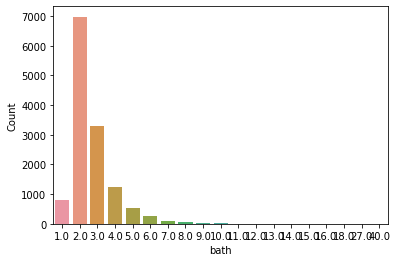

In [19]:
'''
#Bath
==> Impute the null values with median of the column
==> After handling null values, Bucket the Bath Variable based on the frequency, replace bath with 
count > 5 with "5+"
'''

#Imputing Null Value with Median of the column
median_bath = df['bath'].median()
df['bath'] = df['bath'].fillna(median_bath)


#Checking the distribution of data based on bath values
print('Distribution before binning')
temp = df[['bath', 'price']].groupby(by=['bath']).count().reset_index().rename(columns={"price": "Count"})
sns.barplot(x = temp['bath'], y = temp['Count'] )


df['bath'] = [10 if x > 10 else x for x in df['bath']]



Distribution After binning


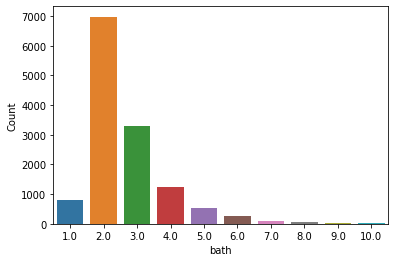

In [20]:
#Checking the distribution of data based on bath values
print('Distribution After binning')
temp = df[['bath', 'price']].groupby(by=['bath']).count().reset_index().rename(columns={"price": "Count"})
sns.barplot(x = temp['bath'], y = temp['Count'] )

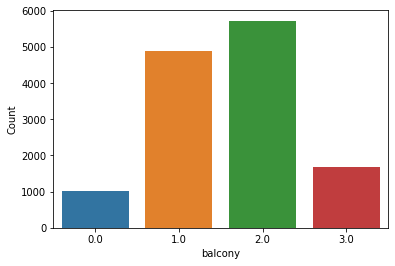

In [21]:
'''
#Balcony
==> Impute the null values with median of the column
'''

#Imputing Null Value with Median of the column
median_balcony = df['balcony'].median()
df['balcony'] = df['balcony'].fillna(median_balcony)
#print(median_balcony)


#Checking the distribution of data based on balcony values
temp = df[['balcony', 'price']].groupby(by=['balcony']).count().reset_index().rename(columns={"price": "Count"})
sns.barplot(x = temp['balcony'], y = temp['Count'] )

In [22]:
#Creating NEW Feature

#==> Combining Bath and balcony to create a new categorical variable

df['bathbalcony'] = [str(int(x)) + str(int(y)) for x,y in zip(df['bath'], df['balcony'])]
df['bedbathbalcony'] = [str(int(x)) + str(int(y)) + str(int(z)) for x,y,z in zip(df['size'], df['bath'], df['balcony'])]

In [23]:
df.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bathbalcony,bedbathbalcony
0,Super built-up Area,12,Electronic City Phase II,2,Coomee,1056,2.0,1.0,39.07,21,221
1,Plot Area,0,Chikka Tirupathi,4,Theanmp,2600,5.0,3.0,120.00,53,453
2,Built-up Area,0,Uttarahalli,3,Other,1440,2.0,3.0,62.00,23,323
3,Super built-up Area,0,Lingadheeranahalli,3,Soiewre,1521,3.0,1.0,95.00,31,331
4,Super built-up Area,0,Kothanur,2,Other,1200,2.0,1.0,51.00,21,221


In [24]:
df.shape

(13320, 11)

Modeling

In [25]:
#Removing outliers from the Total_Sqft column

q_low = df["total_sqft"].quantile(0.005)
q_hi  = df["total_sqft"].quantile(0.99)

df2 = df[(df["total_sqft"] < q_hi) & (df["total_sqft"] > q_low)]
print('New dataset shape:', df2.shape)

New dataset shape: (13119, 11)


In [26]:
#Dummification of categorical variables

cat_col = ['area_type', 'availability', 'location', 'society', 'bathbalcony', 'bedbathbalcony']
df3 = pd.get_dummies(df2, columns=cat_col).reset_index(drop=True)
print('New dataset shape:', df3.shape)

New dataset shape: (13119, 839)


In [27]:
#Removing varuables where Number of Zeros are more than the threshold

overfit = []
for i in df3.columns:
    counts = df3[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(df3) * 100 > 99.98:
        overfit.append(i)

overfit = list(overfit)
df3 = df3.drop(overfit, axis=1)

In [28]:
df3.shape

(13119, 768)

In [29]:
#Splitting the dataset into train and test

X_train, X_test, y_train, y_test = train_test_split(df3.drop(['price'], axis=1) ,  np.log1p(df3['price']), 
                                                    test_size=0.25, random_state=42)

In [30]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

def r2(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kfolds, n_jobs=-1)
    return scores

In [31]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = RidgeCV(alphas=alphas_alt, cv=kfolds)

lasso = LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds)

elasticnet = ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio)
                                        
svr = SVR(C= 20, epsilon= 0.008, gamma=0.0003,)


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

randomforest = RandomForestRegressor(n_estimators=100,
                                        criterion='mse',
                                        max_depth=4,
                                        min_samples_split=5,
                                        min_samples_leaf=10,
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.1,
                                        random_state=42
                                 )
    
                                
print('TEST score on CV')

score = r2(ridge, X_train, y_train)
print("Ridge Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(lasso, X_train, y_train)
print("Lasso Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(elasticnet, X_train, y_train)
print("elasticnet Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(svr, X_train, y_train)
print("Support Vector Regression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(gbr, X_train, y_train)
print("Gradient Boosting Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(lightgbm, X_train, y_train)
print("Light GBM Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

print('*****************************************')
score = r2(randomforest, X_train, y_train)
print("Random Forest Regressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), )

TEST score on CV
Ridge Regression score: 0.7767 (0.0221)

*****************************************
Lasso Regression score: 0.7935 (0.0218)

*****************************************
elasticnet Regression score: 0.7906 (0.0215)

*****************************************
Support Vector Regression score: 0.7435 (0.0156)

*****************************************
Gradient Boosting Regressor score: 0.7934 (0.0216)

*****************************************
Light GBM Regressor score: 0.7746 (0.0191)

*****************************************
Random Forest Regressor score: 0.4396 (0.0260)



In [32]:
print('Fitting the testing dataset')

print('elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)

print('Lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)

print('Ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)

print('Svr')
svr_model_full_data = svr.fit(X_train, y_train)

print('GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)

print('random forest')
randomforest_model_full_data = randomforest.fit(X_train, y_train)

print('lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

Fitting the testing dataset
elasticnet
Lasso
Ridge
Svr
GradientBoosting
random forest
lightgbm


In [35]:
def blend_models_predict(X_test):
    return ((0.3 * elastic_model_full_data.predict(X_test)) + \
            (0.1 * lasso_model_full_data.predict(X_test)) + \
            (0.15 * ridge_model_full_data.predict(X_test)) + \
            (0.05 * svr_model_full_data.predict(X_test)) + \
            (0.3 * gbr_model_full_data.predict(X_test)) + \
            (0.1 * lgb_model_full_data.predict(X_test))
            )

prediction = blend_models_predict(X_test)

In [36]:
r2 = r2_score(y_test, prediction, multioutput='variance_weighted')
print("R2 on the test dataset:",round(r2,3))

R2 on the test dataset: 0.791
